In [1]:
#for this to work you will need to install any required libraries first
 #pmdarima # for the auto arima model
 #pandas_datareader # for reading data from the web

#on windows from a command prompt (start run cmd) paste and run this line
    #pip install ####LIBRARYNAME####
#or in anaconda make sure the library is included in the envorinments page (search installed/uninstalled) and check and apply and then wait many minutes...
    

#import all libraries used below
import pandas as pd # for data analytics
import pandas_datareader.data as pdr # for reading web data
import datetime as dt #for managing dates
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for statistics visuals
from statsmodels.tsa.stattools import adfuller as adf # for the adf stationary check
from statsmodels.tsa.seasonal import seasonal_decompose as sd # for a seasonal decomposition
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima as aa #for selecting the model options
import numpy as np # for math
from sklearn.metrics import mean_squared_error as mse #for RMSE calculation
from sklearn.metrics import mean_absolute_error as mae #for MAE calculation

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print('Done')


Done


In [2]:
#this seems to have been depreciated
#df = web.get_data_yahoo(['NVDA'], start=datetime.datetime(2022, 1, 1), end=datetime.datetime(2023, 12, 2))['Close']
#https://pandas-datareader.readthedocs.io/en/latest/remote_data.html

#the stooq data reader is working as of Jan 2024 - use whatever stock ticker you want
df = pdr.DataReader('NVDA', 'stooq')
print(df.head())

#write to local csv
df.to_csv("M4_stock_history.csv")

#load up to the end of 2023
stock = pd.read_csv("M4_stock_history.csv")
print(stock.head())

#replace the index with the date and delete the redundant date
stock.index = pd.to_datetime(stock['Date'], format='%Y-%m-%d')
print(stock.head())

#leave just the closing price
del stock['Date']
del stock['Open']
del stock['High']
del stock['Low']
del stock['Volume']

#reserve 2024 data for final check and only include up to the end of 2023 for training/testing
stock_2025 = stock[stock.index >= pd.to_datetime("2025-01-01", format='%Y-%m-%d')]
stock = stock[stock.index < pd.to_datetime("2025-01-01", format='%Y-%m-%d')]

#convert the index to show daily data
#stock.index = pd.DatetimeIndex(stock.index).to_freq('D')
stock = stock.asfreq('D')
stock_2025 = stock_2025.asfreq('D')
stock = stock.fillna(method='ffill')
stock_2025 = stock_2025.fillna(method='ffill')
print(stock.head())
print(stock.index)

               Open      High       Low   Close      Volume
Date                                                       
2024-04-17  883.400  887.7500  839.5000  840.35  49539951.0
2024-04-16  864.325  881.1800  860.6390  874.15  37045302.0
2024-04-15  890.980  906.1300  859.2901  860.01  44307695.0
2024-04-12  896.990  901.7499  875.3000  881.86  42680479.0
2024-04-11  874.200  907.3899  869.2600  906.16  43163727.0
         Date     Open      High       Low   Close      Volume
0  2024-04-17  883.400  887.7500  839.5000  840.35  49539951.0
1  2024-04-16  864.325  881.1800  860.6390  874.15  37045302.0
2  2024-04-15  890.980  906.1300  859.2901  860.01  44307695.0
3  2024-04-12  896.990  901.7499  875.3000  881.86  42680479.0
4  2024-04-11  874.200  907.3899  869.2600  906.16  43163727.0
                  Date     Open      High       Low   Close      Volume
Date                                                                   
2024-04-17  2024-04-17  883.400  887.7500  839.5000  840.3

# Visualize the Stock data and check for stationary assumptions
load the data from the web reader and then store into a local csv file

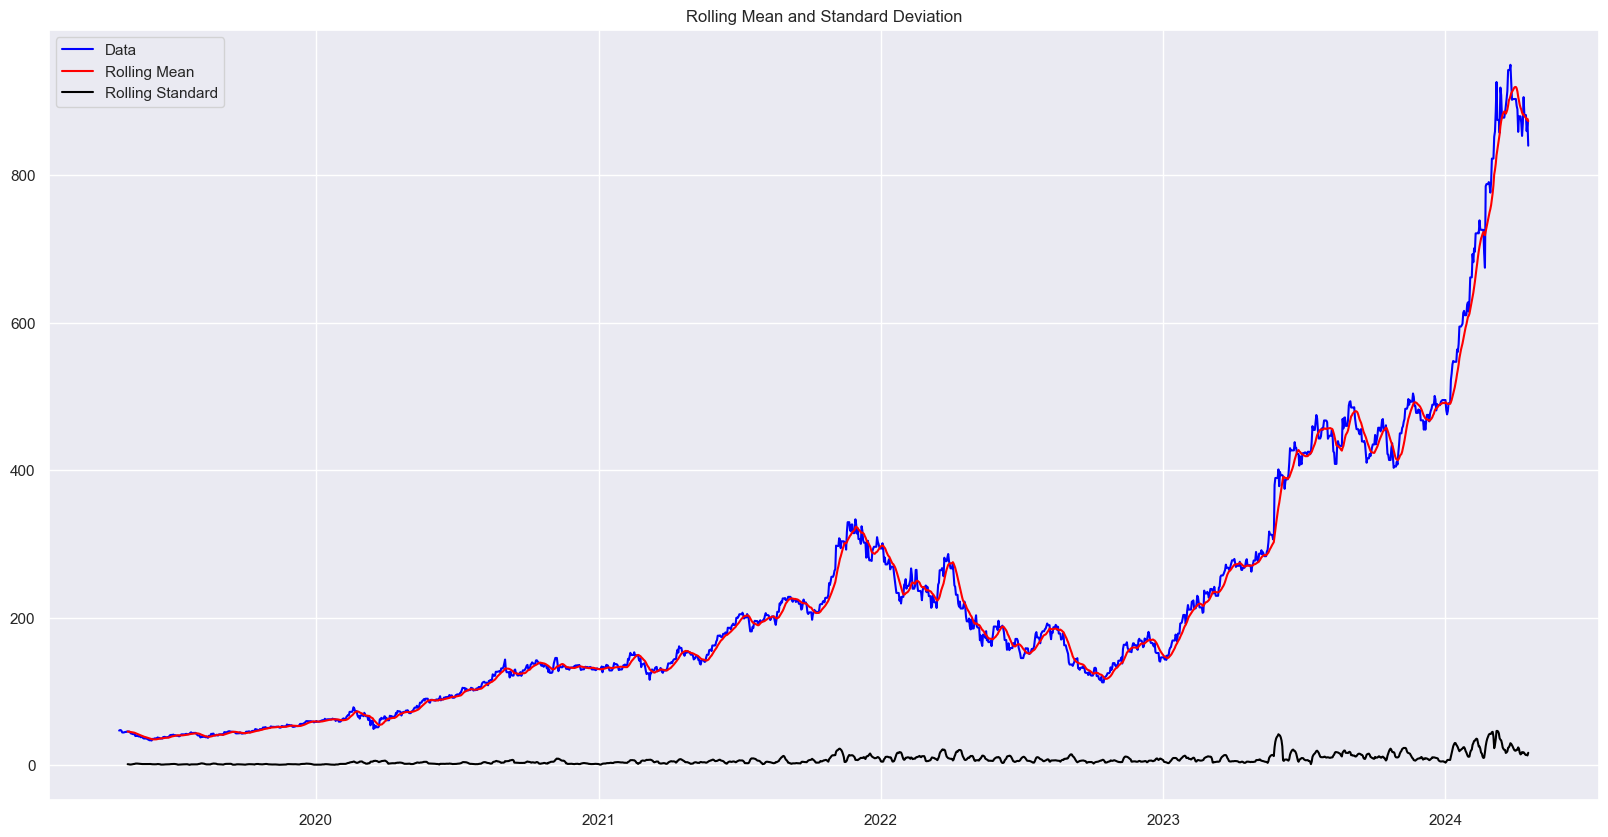

Results of ADF test
Test Statistics                   1.446680
p-value                           0.997316
No. of lags used                 19.000000
Number of Observations used    1803.000000
Critical Value (1%)              -3.433982
Critical Value (5%)              -2.863144
Critical Value (10%)             -2.567624
dtype: float64


In [3]:
#plot some stuff
sns.set()

#4. Checking whether the data is stationary or not:  Before checking that, we need to know what stationary data means…right? The data is stationary if they do not have trend or any seasonal effects. And if the data is non-stationary, then we have to convert it to stationary data before fitting into the ARIMA model. To check whether the data is stationary, we will use Augmented Dicky Fuller(ADF) test.

#define a function for the ADF test
def test_adf(timeseries):
  moving_avg=timeseries.rolling(12).mean()
  moving_std=timeseries.rolling(12).std()
  plt.figure(figsize=(20,10))
  plt.plot(timeseries, color='blue', label='Data')
  plt.plot(moving_avg, color='red', label='Rolling Mean')
  plt.plot(moving_std, color='black', label='Rolling Standard')
  plt.legend(loc='best')
  plt.title('Rolling Mean and Standard Deviation')
  plt.show(block=False)
  print("Results of ADF test")
  adft=adf(timeseries,autolag='AIC')
  output=pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of Observations used']) 
  for key,value in adft[4].items():
    output['Critical Value (%s)'%key]=value
  print(output)

test_adf(stock)

#if the test statistic is greater than the critical values, so p>0.05, we fail to reject the null hypothesis meaning that the time series data is non-stationary
#in this case the data is stationary so we do not need to do a log conversion or anything like that


<Figure size 640x480 with 0 Axes>

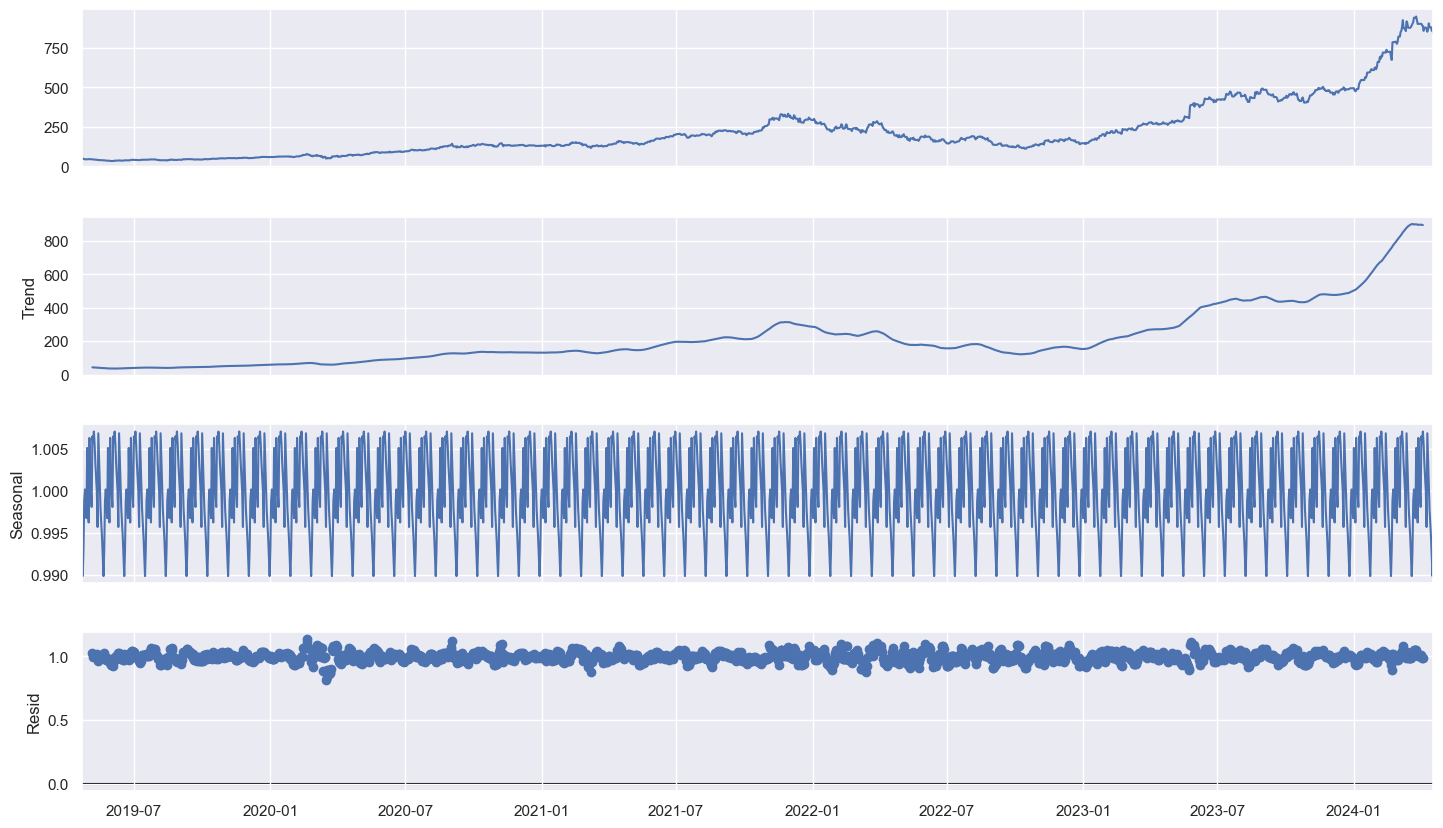

In [4]:
#we should also check the seasinality components to see if this will help in the modelling
#see what happens when you change the seasonality from 7 to 14 to 28
result=sd(stock,model='multiplicative',period=28)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16,9)

# split the data into multiple training and testing sets
choice of split is up to you so we will try a few and compare results
plot the two to see the difference and do different models as a 'cross validation' approach

In [5]:
train_2021 = stock[stock.index < pd.to_datetime("2021-01-01", format='%Y-%m-%d')]
test_2021 = stock[stock.index >= pd.to_datetime("2021-01-01", format='%Y-%m-%d')]
pd.DatetimeIndex(train_2021.index).to_period('D')
pd.DatetimeIndex(test_2021.index).to_period('D')

train_2022 = stock[stock.index < pd.to_datetime("2022-01-01", format='%Y-%m-%d')]
test_2022 = stock[stock.index >= pd.to_datetime("2022-01-01", format='%Y-%m-%d')]
pd.DatetimeIndex(train_2022.index).to_period('D')
pd.DatetimeIndex(test_2022.index).to_period('D')

train_2023 = stock[stock.index < pd.to_datetime("2023-01-01", format='%Y-%m-%d')]
test_2023 = stock[stock.index >= pd.to_datetime("2023-01-01", format='%Y-%m-%d')]
pd.DatetimeIndex(train_2023.index).to_period('D')
pd.DatetimeIndex(test_2023.index).to_period('D')

#test
train_2024 = stock[stock.index < pd.to_datetime("2024-01-01", format='%Y-%m-%d')]
test_2024 = stock[stock.index >= pd.to_datetime("2024-01-01", format='%Y-%m-%d')]
pd.DatetimeIndex(train_2024.index).to_period('D')
pd.DatetimeIndex(test_2024.index).to_period('D')

train_2025 = stock[stock.index < pd.to_datetime("2025-01-01", format='%Y-%m-%d')]
test_2025 = stock[stock.index >= pd.to_datetime("2025-01-01", format='%Y-%m-%d')]
pd.DatetimeIndex(train_2025.index).to_period('D')
pd.DatetimeIndex(test_2025.index).to_period('D')


print(train_2021.head())
print(train_2021.index)
print(test_2021.head())
print(test_2021.index)
print(train_2022.head())
print(test_2022.head())
print(test_2022.index)
print(train_2023.head())
print(test_2023.head())
print(test_2023.index)

print(train_2024.head())
print(test_2024.head())
print(test_2024.index)

print(train_2025.head())
print(test_2025.head())
print(test_2025.index)

              Close
Date               
2019-04-22  46.8192
2019-04-23  47.3628
2019-04-24  47.4888
2019-04-25  46.4365
2019-04-26  44.2431
DatetimeIndex(['2019-04-22', '2019-04-23', '2019-04-24', '2019-04-25',
               '2019-04-26', '2019-04-27', '2019-04-28', '2019-04-29',
               '2019-04-30', '2019-05-01',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=620, freq='D')
              Close
Date               
2021-01-01  130.310
2021-01-02  130.310
2021-01-03  130.310
2021-01-04  130.900
2021-01-05  133.808
DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2024-04-08', '2024-04-09', '2024-04-1

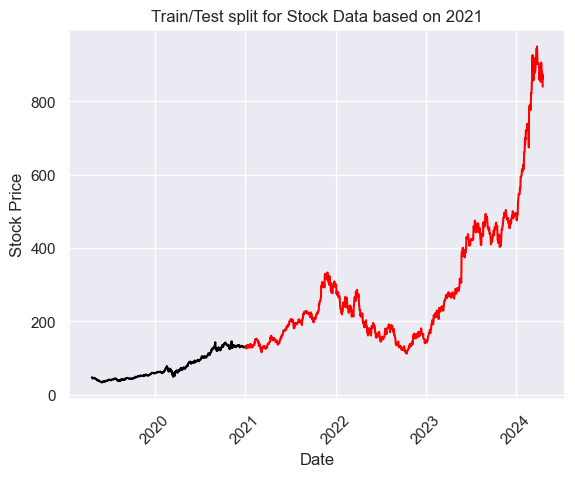

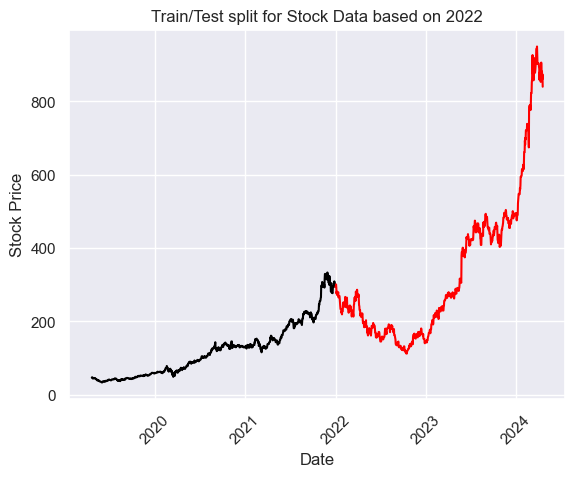

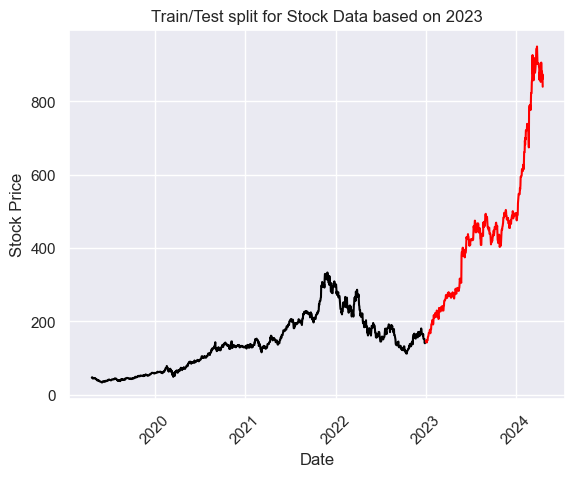

In [6]:
#2021 split plot
plt.plot(train_2021.index, train_2021['Close'], color = "black")
plt.plot(test_2021.index, test_2021['Close'], color = "red")
plt.ylabel('Stock Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Stock Data based on 2021")
plt.show()

#2022 split plot
plt.plot(train_2022.index, train_2022['Close'], color = "black")
plt.plot(test_2022.index, test_2022['Close'], color = "red")
plt.ylabel('Stock Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Stock Data based on 2022")
plt.show()

#2023
plt.plot(train_2023.index, train_2023['Close'], color = "black")
plt.plot(test_2023.index, test_2023['Close'], color = "red")
plt.ylabel('Stock Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Stock Data based on 2023")
plt.show()

# Autoregressive Moving Average (ARIMA) Model comparisons
Try different techniques and see what options result in better models

In [7]:
#use the auto arima to compare which parameters have the best score... is it the same for both 2021 and 2022?
model_ARIMA_options_2021 = aa(train_2021
 ,start_p=0
 ,start_1=0
 ,test='adf'
 ,max_p=7
 ,max_q=7
 ,m=1
 ,d=None
 ,seasonal=False
 ,start_P=0
 ,D=0
 ,trace=True
 ,error_action='ignore'
 ,suppress_warning=True
 ,stepwise=True)

#use the auto arima to compare which parameters have the best score... is it the same for both 2021 and 2022?
model_ARIMA_options_2022 = aa(train_2022
 ,start_p=0
 ,start_1=0
 ,test='adf'
 ,max_p=7
 ,max_q=7
 ,m=1
 ,d=None
 ,seasonal=False
 ,start_P=0
 ,D=0
 ,trace=True
 ,error_action='ignore'
 ,suppress_warning=True
 ,stepwise=True)

model_ARIMA_options_2023 = aa(train_2023
 ,start_p=0
 ,start_1=0
 ,test='adf'
 ,max_p=7
 ,max_q=7
 ,m=1
 ,d=None
 ,seasonal=False
 ,start_P=0
 ,D=0
 ,trace=True
 ,error_action='ignore'
 ,suppress_warning=True
 ,stepwise=True)


model_ARIMA_options_2024 = aa(train_2024
 ,start_p=0
 ,start_1=0
 ,test='adf'
 ,max_p=7
 ,max_q=7
 ,m=1
 ,d=None
 ,seasonal=False
 ,start_P=0
 ,D=0
 ,trace=True
 ,error_action='ignore'
 ,suppress_warning=True
 ,stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2657.655, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2665.687, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2655.867, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2655.669, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2666.291, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2657.635, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2659.580, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2657.237, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.817 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5275.097, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5286.476, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5280.661, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5279.036, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=528

# 2021 options
Try different techniques and see what options result in better models

Date
2021-01-01    130.39484
2021-01-02    130.39484
2021-01-03    130.39484
2021-01-04    130.39484
2021-01-05    130.39484
Freq: D, Name: Predictions, dtype: float64
Date
2021-01-01    130.424910
2021-01-02    130.402290
2021-01-03    130.412072
2021-01-04    130.407842
2021-01-05    130.409671
Freq: D, Name: Predictions, dtype: float64
Date
2021-01-01    130.396610
2021-01-02    130.284994
2021-01-03    130.321055
2021-01-04    130.321055
2021-01-05    130.321055
Freq: D, Name: Predictions, dtype: float64


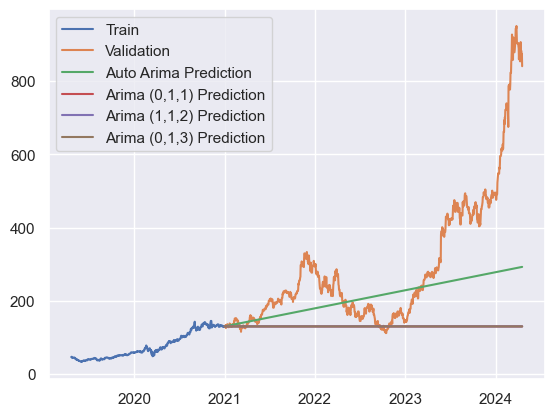

In [8]:
#now do the actual model fit and forecast
model_ARIMA_options_2021.fit(train_2021)
#model_ARIMA_options_2022.fit(train_2022)


forecast_2021_autoarima = model_ARIMA_options_2021.predict(n_periods=len(test_2021))
forecast_2021_autoarima = pd.DataFrame(forecast_2021_autoarima,index = test_2021.index,columns=['Prediction'])

#also compare some other options
model_2021_011=ARIMA(train_2021, order = (0,1,1))
model_2021_011_fit = model_2021_011.fit()
forecast_2021_011 = model_2021_011_fit.get_forecast(len(test_2021.index))
forecast_2021_011_df = forecast_2021_011.conf_int(alpha = 0.05) 
forecast_2021_011_df["Predictions"] = model_2021_011_fit.predict(start = forecast_2021_011_df.index[0], end = forecast_2021_011_df.index[-1])
forecast_2021_011_df.index = test_2021.index
forecast_2021_011_out = forecast_2021_011_df["Predictions"]
print(forecast_2021_011_out.head())

model_2021_112=ARIMA(train_2021, order = (1,1,2))
model_2021_112_fit = model_2021_112.fit()
forecast_2021_112 = model_2021_112_fit.get_forecast(len(test_2021.index))
forecast_2021_112_df = forecast_2021_112.conf_int(alpha = 0.05) 
forecast_2021_112_df["Predictions"] = model_2021_112_fit.predict(start = forecast_2021_112_df.index[0], end = forecast_2021_112_df.index[-1])
forecast_2021_112_df.index = test_2021.index
forecast_2021_112_out = forecast_2021_112_df["Predictions"]
print(forecast_2021_112_out.head())

model_2021_013=ARIMA(train_2021, order = (0,1,3))
model_2021_013_fit = model_2021_013.fit()
forecast_2021_013 = model_2021_013_fit.get_forecast(len(test_2021.index))
forecast_2021_013_df = forecast_2021_013.conf_int(alpha = 0.05) 
forecast_2021_013_df["Predictions"] = model_2021_013_fit.predict(start = forecast_2021_013_df.index[0], end = forecast_2021_013_df.index[-1])
forecast_2021_013_df.index = test_2021.index
forecast_2021_013_out = forecast_2021_013_df["Predictions"]
print(forecast_2021_013_out.head())

#plot the predictions for validation set
plt.plot(train_2021, label='Train')
plt.plot(test_2021, label='Validation')
plt.plot(forecast_2021_autoarima, label='Auto Arima Prediction')
plt.plot(forecast_2021_011_out, label='Arima (0,1,1) Prediction')
plt.plot(forecast_2021_112_out, label='Arima (1,1,2) Prediction')
plt.plot(forecast_2021_013_out, label='Arima (0,1,3) Prediction')
plt.legend()
plt.show()




# 2022 options
Try different techniques and see what options result in better models

Date
2022-01-01    294.052252
2022-01-02    294.052252
2022-01-03    294.052252
2022-01-04    294.052252
2022-01-05    294.052252
Freq: D, Name: Predictions, dtype: float64
Date
2022-01-01    294.827614
2022-01-02    294.405267
2022-01-03    294.677864
2022-01-04    294.501921
2022-01-05    294.615481
Freq: D, Name: Predictions, dtype: float64


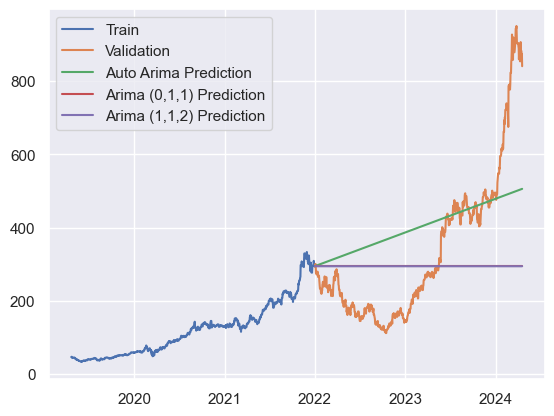

In [9]:
#now do the actual model fit and forecast
model_ARIMA_options_2022.fit(train_2022)

forecast_2022_autoarima = model_ARIMA_options_2022.predict(n_periods=len(test_2022))
forecast_2022_autoarima = pd.DataFrame(forecast_2022_autoarima,index = test_2022.index,columns=['Prediction'])

#also compare some other options
model_2022_011=ARIMA(train_2022, order = (0,1,1))
model_2022_011_fit = model_2022_011.fit()
forecast_2022_011 = model_2022_011_fit.get_forecast(len(test_2022.index))
forecast_2022_011_df = forecast_2022_011.conf_int(alpha = 0.05) 
forecast_2022_011_df["Predictions"] = model_2022_011_fit.predict(start = forecast_2022_011_df.index[0], end = forecast_2022_011_df.index[-1])
forecast_2022_011_df.index = test_2022.index
forecast_2022_011_out = forecast_2022_011_df["Predictions"]
print(forecast_2022_011_out.head())

model_2022_112=ARIMA(train_2022, order = (1,1,2))
model_2022_112_fit = model_2022_112.fit()
forecast_2022_112 = model_2022_112_fit.get_forecast(len(test_2022.index))
forecast_2022_112_df = forecast_2022_112.conf_int(alpha = 0.05) 
forecast_2022_112_df["Predictions"] = model_2022_112_fit.predict(start = forecast_2022_112_df.index[0], end = forecast_2022_112_df.index[-1])
forecast_2022_112_df.index = test_2022.index
forecast_2022_112_out = forecast_2022_112_df["Predictions"]
print(forecast_2022_112_out.head())

#plot the predictions for validation set
plt.plot(train_2022, label='Train')
plt.plot(test_2022, label='Validation')
plt.plot(forecast_2022_autoarima, label='Auto Arima Prediction')
plt.plot(forecast_2022_011_out, label='Arima (0,1,1) Prediction')
plt.plot(forecast_2022_112_out, label='Arima (1,1,2) Prediction')
plt.legend()
plt.show()

# Which model is better? - compare RMSE

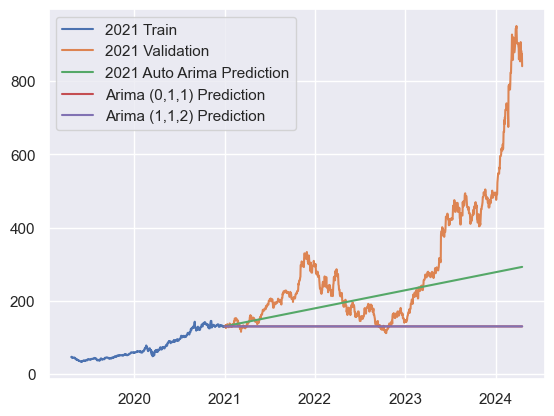

ARIMA(0,1,1) RMSE 2021 :  245.64873609393894
ARIMA(1,1,2) RMSE 2021:  245.63926063864537
AutoArima RMSE 2021 :  172.63398253370494

ARIMA(0,1,1) MAE 2021 :  163.65645043159483
ARIMA(1,1,2) MAE 2021:  163.6438194396212
AutoArima MAE 2021 :  108.91371180432874


In [10]:
#plot the predictions for validation set FOR 2021
plt.plot(train_2021, label='2021 Train')
plt.plot(test_2021, label='2021 Validation')
plt.plot(forecast_2021_autoarima, label='2021 Auto Arima Prediction')
plt.plot(forecast_2021_011_out, label='Arima (0,1,1) Prediction')
plt.plot(forecast_2021_112_out, label='Arima (1,1,2) Prediction')
plt.legend()
plt.show()

rmse_2021_011 = np.sqrt(mse(test_2021.values, forecast_2021_011_out))
print("ARIMA(0,1,1) RMSE 2021 : ",rmse_2021_011)
rmse_2021_112 = np.sqrt(mse(test_2021.values, forecast_2021_112_out))
print("ARIMA(1,1,2) RMSE 2021: ",rmse_2021_112)
rmse_2021_AutoArima = np.sqrt(mse(test_2021.values, forecast_2021_autoarima))
print("AutoArima RMSE 2021 : ",rmse_2021_AutoArima)

print()

mae_2021_011 = mae(test_2021.values, forecast_2021_011_out)
print("ARIMA(0,1,1) MAE 2021 : ",mae_2021_011)
mae_2021_112 = mae(test_2021.values, forecast_2021_112_out)
print("ARIMA(1,1,2) MAE 2021: ",mae_2021_112)
mae_2021_AutoArima = mae(test_2021.values, forecast_2021_autoarima)
print("AutoArima MAE 2021 : ",mae_2021_AutoArima)


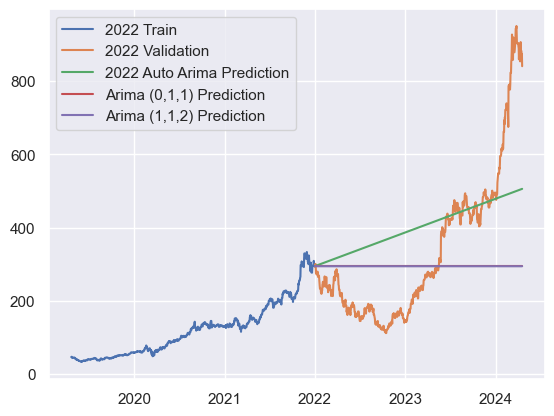

ARIMA(0,1,1) RMSE 2022 :  206.5641812395131
ARIMA(1,1,2) RMSE 2022:  206.4583467351542
AutoArima RMSE 2022:  168.96979868632312

ARIMA(0,1,1) MAE 2022 :  155.93705941741493
ARIMA(1,1,2) MAE 2022:  156.03726102475287
AutoArima MAE 2022 :  134.16528246245383


In [11]:
#plot the predictions for validation set FOR 2022
plt.plot(train_2022, label='2022 Train')
plt.plot(test_2022, label='2022 Validation')
plt.plot(forecast_2022_autoarima, label='2022 Auto Arima Prediction')
plt.plot(forecast_2022_011_out, label='Arima (0,1,1) Prediction')
plt.plot(forecast_2022_112_out, label='Arima (1,1,2) Prediction')
plt.legend()
plt.show()

rmse_2022_011 = np.sqrt(mse(test_2022.values, forecast_2022_011_out))
print("ARIMA(0,1,1) RMSE 2022 : ",rmse_2022_011)
rmse_2022_112 = np.sqrt(mse(test_2022.values, forecast_2022_112_out))
print("ARIMA(1,1,2) RMSE 2022: ",rmse_2022_112)
rmse_2022_AutoArima = np.sqrt(mse(test_2022.values, forecast_2022_autoarima))
print("AutoArima RMSE 2022: ",rmse_2022_AutoArima)

print()

mae_2022_011 = mae(test_2022.values, forecast_2022_011_out)
print("ARIMA(0,1,1) MAE 2022 : ",mae_2022_011)
mae_2022_112 = mae(test_2022.values, forecast_2022_112_out)
print("ARIMA(1,1,2) MAE 2022: ",mae_2022_112)
mae_2022_AutoArima = mae(test_2022.values, forecast_2022_autoarima)
print("AutoArima MAE 2022 : ",mae_2022_AutoArima)


# Finally - use the withheld validation data set for 2024
# what parameters will you use?
who can get the lowest RMSE???

In [12]:
#this is left as an individual assignment
#you are going to submit the code in this snippet and your output as a mini quiz on the hub
#I want to see your RMSE calculation on the 2024 data and describe the model you chose.

Date
2023-01-01    146.138283
2023-01-02    146.138283
2023-01-03    146.138283
2023-01-04    146.138283
2023-01-05    146.138283
Freq: D, Name: Predictions, dtype: float64
Date
2023-01-01    146.189300
2023-01-02    146.141002
2023-01-03    146.168212
2023-01-04    146.152883
2023-01-05    146.161519
Freq: D, Name: Predictions, dtype: float64
Date
2023-01-01    146.291292
2023-01-02    146.298841
2023-01-03    146.318528
2023-01-04    146.318528
2023-01-05    146.318528
Freq: D, Name: Predictions, dtype: float64


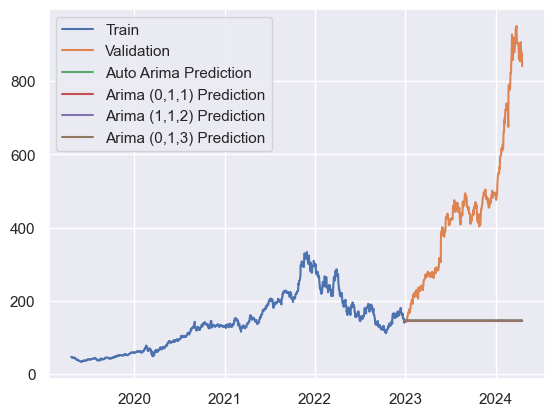

In [13]:
#2023 Options
#now do the actual model fit and forecast
model_ARIMA_options_2023.fit(train_2023)

forecast_2023_autoarima = model_ARIMA_options_2023.predict(n_periods=len(test_2023))
forecast_2023_autoarima = pd.DataFrame(forecast_2023_autoarima,index = test_2023.index,columns=['Prediction'])

#also compare some other options
model_2023_011=ARIMA(train_2023, order = (0,1,1))
model_2023_011_fit = model_2023_011.fit()
forecast_2023_011 = model_2023_011_fit.get_forecast(len(test_2023.index))
forecast_2023_011_df = forecast_2023_011.conf_int(alpha = 0.05) 
forecast_2023_011_df["Predictions"] = model_2023_011_fit.predict(start = forecast_2023_011_df.index[0], end = forecast_2023_011_df.index[-1])
forecast_2023_011_df.index = test_2023.index
forecast_2023_011_out = forecast_2023_011_df["Predictions"]
print(forecast_2023_011_out.head())

model_2023_112=ARIMA(train_2023, order = (1,1,2))
model_2023_112_fit = model_2023_112.fit()
forecast_2023_112 = model_2023_112_fit.get_forecast(len(test_2023.index))
forecast_2023_112_df = forecast_2023_112.conf_int(alpha = 0.05) 
forecast_2023_112_df["Predictions"] = model_2023_112_fit.predict(start = forecast_2023_112_df.index[0], end = forecast_2023_112_df.index[-1])
forecast_2023_112_df.index = test_2023.index
forecast_2023_112_out = forecast_2023_112_df["Predictions"]
print(forecast_2023_112_out.head())

#added for the new trained data
model_2023_013=ARIMA(train_2023, order = (0,1,3))
model_2023_013_fit = model_2023_013.fit()
forecast_2023_013 = model_2023_013_fit.get_forecast(len(test_2023.index))
forecast_2023_013_df = forecast_2023_013.conf_int(alpha = 0.05) 
forecast_2023_013_df["Predictions"] = model_2023_013_fit.predict(start = forecast_2023_013_df.index[0], end = forecast_2023_013_df.index[-1])
forecast_2023_013_df.index = test_2023.index
forecast_2023_013_out = forecast_2023_013_df["Predictions"]
print(forecast_2023_013_out.head())


#plot the predictions for validation set
plt.plot(train_2023, label='Train')
plt.plot(test_2023, label='Validation')
plt.plot(forecast_2023_autoarima, label='Auto Arima Prediction')
plt.plot(forecast_2023_011_out, label='Arima (0,1,1) Prediction')
plt.plot(forecast_2023_112_out, label='Arima (1,1,2) Prediction')
plt.plot(forecast_2023_013_out, label='Arima (0,1,3) Prediction')
plt.legend()
plt.show()

Date
2024-01-01    495.22
2024-01-02    495.22
2024-01-03    495.22
2024-01-04    495.22
2024-01-05    495.22
Freq: D, Name: Predictions, dtype: float64
Date
2024-01-01    495.413752
2024-01-02    495.235575
2024-01-03    495.389606
2024-01-04    495.256449
2024-01-05    495.371561
Freq: D, Name: Predictions, dtype: float64
Date
2024-01-01    495.218815
2024-01-02    495.219806
2024-01-03    495.219662
2024-01-04    495.219662
2024-01-05    495.219662
Freq: D, Name: Predictions, dtype: float64


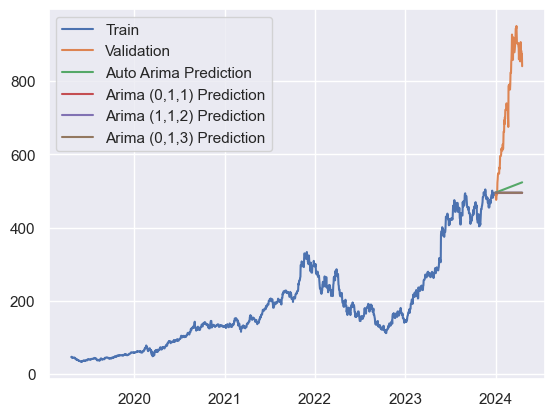

In [14]:
#now do the actual model fit and forecast
model_ARIMA_options_2024.fit(train_2024)

forecast_2024_autoarima = model_ARIMA_options_2024.predict(n_periods=len(test_2024))
forecast_2024_autoarima = pd.DataFrame(forecast_2024_autoarima,index = test_2024.index,columns=['Prediction'])

#also compare some other options
model_2024_011=ARIMA(train_2024, order = (0,1,1))
model_2024_011_fit = model_2024_011.fit()
forecast_2024_011 = model_2024_011_fit.get_forecast(len(test_2024.index))
forecast_2024_011_df = forecast_2024_011.conf_int(alpha = 0.05) 
forecast_2024_011_df["Predictions"] = model_2024_011_fit.predict(start = forecast_2024_011_df.index[0], end = forecast_2024_011_df.index[-1])
forecast_2024_011_df.index = test_2024.index
forecast_2024_011_out = forecast_2024_011_df["Predictions"]
print(forecast_2024_011_out.head())

model_2024_112=ARIMA(train_2024, order = (1,1,2))
model_2024_112_fit = model_2024_112.fit()
forecast_2024_112 = model_2024_112_fit.get_forecast(len(test_2024.index))
forecast_2024_112_df = forecast_2024_112.conf_int(alpha = 0.05) 
forecast_2024_112_df["Predictions"] = model_2024_112_fit.predict(start = forecast_2024_112_df.index[0], end = forecast_2024_112_df.index[-1])
forecast_2024_112_df.index = test_2024.index
forecast_2024_112_out = forecast_2024_112_df["Predictions"]
print(forecast_2024_112_out.head())

#added for the new trained data
model_2024_013=ARIMA(train_2024, order = (0,1,3))
model_2024_013_fit = model_2024_013.fit()
forecast_2024_013 = model_2024_013_fit.get_forecast(len(test_2024.index))
forecast_2024_013_df = forecast_2024_013.conf_int(alpha = 0.05) 
forecast_2024_013_df["Predictions"] = model_2024_013_fit.predict(start = forecast_2024_013_df.index[0], end = forecast_2024_013_df.index[-1])
forecast_2024_013_df.index = test_2024.index
forecast_2024_013_out = forecast_2024_013_df["Predictions"]
print(forecast_2024_013_out.head())


#plot the predictions for validation set
plt.plot(train_2024, label='Train')
plt.plot(test_2024, label='Validation')
plt.plot(forecast_2024_autoarima, label='Auto Arima Prediction')
plt.plot(forecast_2024_011_out, label='Arima (0,1,1) Prediction')
plt.plot(forecast_2024_112_out, label='Arima (1,1,2) Prediction')
plt.plot(forecast_2024_013_out, label='Arima (0,1,3) Prediction')
plt.legend()
plt.show()